# Convergence

In [109]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from ema_workbench import (MultiprocessingEvaluator, ema_logging, RealParameter, ScalarOutcome, Constant,
                           Model, HypervolumeMetric, save_results)
from ema_workbench.em_framework.optimization import (GenerationalBorg, epsilon_nondominated, to_problem, ArchiveLogger,
                                                     EpsilonProgress)

if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

### BASE CASE

In [110]:
# Model definition

from model_zambezi_OPT import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    # print('len kwargs is', len(kwargs)) = 230
    Hydropower, Environment, Irrigation = tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation

# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE)]


#Problem definition
problem = to_problem(model, searchover="levers")


In [111]:
#Run definition

nfe = 200000 #
seeds = 5
run_comment = 'BC'
run_label = f"{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()


'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\BC_200000nfe_5seed'

In [112]:
#Change the load archives method of the ArchiveLogger class

import tarfile
import os
import pandas as pd

def alternative_load_archives(filename):
    archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), index_col=0)
                if not df.empty:
                    archives[int(key)] = df
    #print(archives)
    return archives

ArchiveLogger.load_archives = alternative_load_archives


In [113]:
#Merge convergences 

convergences = []
for i in range(seeds):
    df = pd.read_csv(f"convergence{i}.csv")
    convergences.append(df)
    #f'convergence{i}' = pd.read_csv(f"{run_name}/convergence{i}.csv") 
    #print(f'convergence{i}')

# Load the archives
all_archives = []
for i in range(seeds):
    archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    all_archives.append(archives)


column_names = ['Hydropower', 'Environment', 'Irrigation']

results_list = []
for i in range(seeds):
    result = pd.read_csv(f"results_seed{i}.csv") # Create the results list, containing dataframes with the results per seed 
    globals()[f'df_{i}'] = pd.read_csv(f"results_seed{i}.csv", usecols = column_names) # create dataframes per seed with results for analysis
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    results_list.append(result)



In [6]:
# Define the reference list
reference_set = epsilon_nondominated(results_list, [0.4] * len(model.outcomes), problem)  # [0.05]
len(reference_set)
#print('reference_set type is', type(reference_set))

126

In [7]:
#Define the hypervolumemetric
hv = HypervolumeMetric(reference_set, problem)

from datetime import datetime

before = datetime.now()
print("time before is", before)

time before is 2024-02-26 11:38:18.741572


In [14]:
# Calculate the metrics
metrics_by_seed = []
for archives in all_archives:
    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "hypervolume": hv.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)
    metrics.sort_values(by="nfe", inplace=True)
    metrics_name = 'metrics.csv'
    #metrics.to_csv(os.path.join(cwd, metrics_name))

    metrics_by_seed.append(metrics)


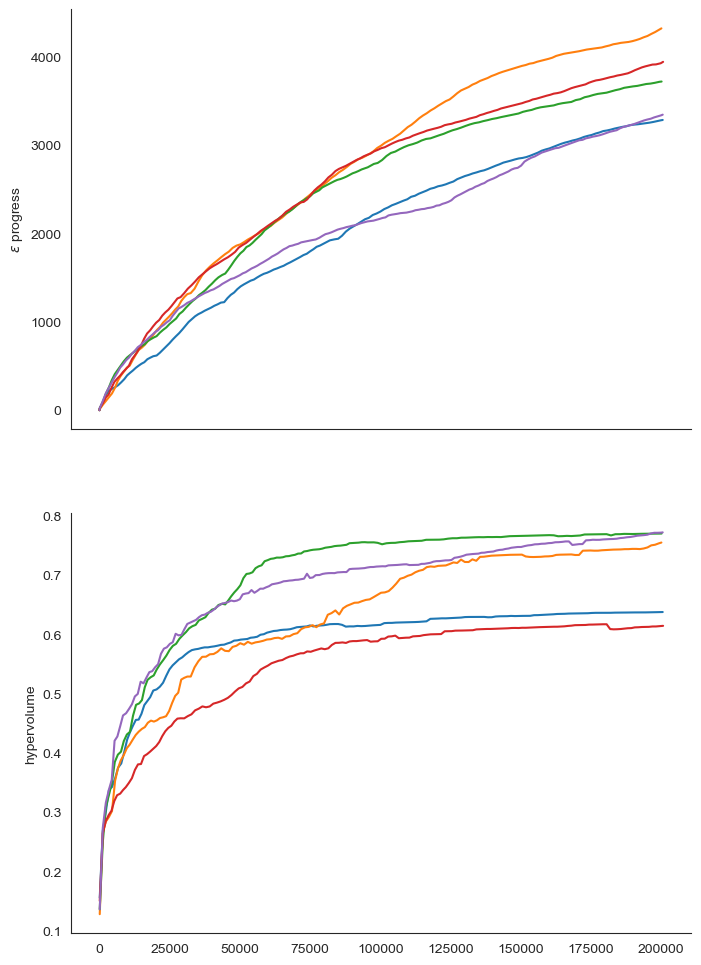

It took 0:06:04.575362 time to do 99705 nfes


In [15]:
# Visualize convergence metrics
sns.set_style("white")
fig, axes = plt.subplots(nrows=2, figsize=(8, 12), sharex=True)

ax1, ax2 = axes
import matplotlib.pyplot as plt

for metrics, convergence in zip(metrics_by_seed, convergences):
    #plt.rcParams["font.family"] = "sans-serif"
    ax1.plot(convergence.nfe, convergence.epsilon_progress)
    ax1.set_ylabel("$\epsilon$ progress")    
    
    ax2.plot(metrics.nfe, metrics.hypervolume)
    ax2.set_ylabel("hypervolume")
    
sns.despine(fig)


plt.show()

after = datetime.now()
print(f"It took {after - before} time to do {nfe} nfes")

In [11]:
#Hypervolume hvwfg

import sys
sys.path
path = r'C:\users\whitl\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages'
sys.path.append(path)
sys.path

import hvwfg

array_df0 = df_0.values.copy()
array_df0

array_ref_set = ref_set.values.copy()

arr_df0 = df_0.values.to_numpy().copy()
arr_df0


seed_keys = []
result_values = []
for key, value in archives.items():
    seed_keys.append(key)
    for i in range(len(seed_keys)):
        #print("Key:", key)#, "Value:", value)

hvwfg.wfg(arr_df0, array_ref_set)

In [12]:
# Fitness vector assuming minimization
obj = np.array([[0.3, 0.6],
                [0.4, 0.4],
                [0.6, 0.2]])

ref = np.array([1.1, 1.1])

hvwfg.wfg(obj, ref)


0.6400000000000001

In [123]:
# Get the worst values (Nadir point)

# Load the merged results
column_names = ['Hydropower', 'Environment', 'Irrigation']
df_bc = pd.read_csv(f"merged_results.csv", usecols = column_names)#, index_col=0) #, usecols = column_names)

worst_hyd = df_bc.Hydropower.max()
worst_irr = df_bc.Irrigation.max()
worst_env = df_bc.Environment.max()

worst_list = []
worst_list.append(worst_hyd)
worst_list.append(worst_env)
worst_list.append(worst_irr)

worst_array = np.asarray(worst_list)
worst_array

best_hyd = df_bc.Hydropower.min()
best_irr = df_bc.Irrigation.min()
best_env = df_bc.Environment.min()

best_list = []
best_list.append(best_hyd)
best_list.append(best_env)
best_list.append(best_irr)

In [115]:
print(worst_list)

[20.17937625072075, 3214070.319504687, 3.074369590148062]


In [116]:
import tarfile
import os
import pandas as pd

column_names = ['Hydropower', 'Environment', 'Irrigation']

def alternative_load_archives(filename):
    archives = {}
    normalized_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                normalized_df=(df-df.min())/(df.max()-df.min())
                norm_df=(df['Hydropower']-df.min())/(df.max()-df.min())
                if not df.empty:
                    archives[int(key)] = df
                if not normalized_df.empty:
                    normalized_archives[int(key)] = normalized_df
                    #print(df)
    return archives, normalized_archives

ArchiveLogger.load_archives = alternative_load_archives


In [117]:
#zeros = [0.0,0.0,0.0]
worst_array = np.ascontiguousarray([30.17937625072075, 4214070.319504687, 4.074369590148062])
    #[0.0,0.0,0.0])
norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0])
    #30.17937625072075, 4214070.319504687, 4.074369590148062])
#worst_array = np.asarray(zeros)

In [118]:
#NORMALIZATION?
#normalized_archives

In [119]:
# Load the archives
#all_archives = []
#all_hvs = {}
all_norm_hvs = []
norm_hvs_dict = {}
norm_hvs_dict_0 = {}
norm_hvs_dict_1 = {}
norm_hvs_dict_2 = {}
norm_hvs_dict_3 = {}
norm_hvs_dict_4 = {}
norm_hvs_dict_5 = {}

hvs_dict_0 = {}
hvs_dict_1 = {}
hvs_dict_2 = {}
hvs_dict_3 = {}
hvs_dict_4 = {}
hvs_dict_5 = {}

for i in range(seeds):
    norm_hvs_this_seed = []
    archives, normalized_archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    #print(archives)
    #all_archives.append(archives)
    sorted_archives = dict(sorted(archives.items()))
    for key, value in sorted_archives.items():
        #print(type(value))
        normalized_value=(value-value.min())/(value.max()-value.min())
        o = value.values
        norm_o = normalized_value.values
        #print(type(o))
        #print(value)
        objs = np.ascontiguousarray(o)
        norm_objs = np.ascontiguousarray(norm_o)
        if key < 100:
            print('objs::',o)
            print('norm objs::',norm_o)
            print('worst array::', worst_array)
        #print(objs.shape)
        #array_reference_set = reference_set.values.copy()
        hv = hvwfg.wfg(objs, 
                       worst_array)
        norm_hv = hvwfg.wfg(norm_objs, 
                       norm_worst_array)
        if key < 110:
            print('hv::',hv)
            print('norm_hv::',norm_hv)
        all_hvs.append(hv)
        norm_hvs_this_seed.append(norm_hv)
        
        if i == 0 :
            norm_hvs_dict_0[int(key)] = norm_hv
            hvs_dict_0[int(key)] = hv
        if i == 1 :
            norm_hvs_dict_1[int(key)] = norm_hv
            hvs_dict_1[int(key)] = hv
        if i == 2 :
            norm_hvs_dict_2[int(key)] = norm_hv
            hvs_dict_2[int(key)] = hv
        if i == 3 :
            norm_hvs_dict_3[int(key)] = norm_hv
            hvs_dict_3[int(key)] = hv
        if i == 4 :
            norm_hvs_dict_4[int(key)] = norm_hv
            hvs_dict_4[int(key)] = hv
        if i == 5 :
            norm_hvs_dict_5[int(key)] = norm_hv
            hvs_dict_5[int(key)] = hv

    print('all hvs for seed', i, ':', norm_hvs_this_seed)
            #print("Key:", hv)#, "Value:", value)
norm_hvs_dict_0
    #all_hvs
#all_norm_hvs
    #for i in range(len(all_archives)):
#    print(i)
#print(all_archives)

hv:: 83860138.16570936
norm_hv:: 0.5165752271909221
all hvs for seed 0 : [0.5165752271909221, 0.5765643204832139, 0.6861416443037728, 0.5603416468453569, 0.6314023129113105, 0.589255815985033, 0.6246548091400476, 0.6675264294869815, 0.7511103563164061, 0.5949112438445575, 0.6152895251678968, 0.6979967391471961, 0.6848131545306164, 0.6859645761664251, 0.6619539383149534, 0.6769316460973612, 0.7022441531339703, 0.6482391284118546, 0.646364729338134, 0.6316495671638402, 0.6463349451622372, 0.6397277382445936, 0.661663906425231, 0.6666008504488913, 0.6754410007795948, 0.689210054436527, 0.7252806037764846, 0.7309740888589378, 0.6962753015999398, 0.689664855667487, 0.7209858575350561, 0.7617079777269168, 0.7208187532673425, 0.7156210353284166, 0.7207306279257117, 0.6438866164849314, 0.6456053994669357, 0.6289485870208769, 0.6364805089204064, 0.6412627572463521, 0.6421169369007487, 0.6408199608913038, 0.6451426647078666, 0.6460239862072931, 0.6236808163662514, 0.6369860500224565, 0.626406782

{100: 0.5165752271909221,
 1188: 0.5765643204832139,
 2279: 0.6861416443037728,
 3373: 0.5603416468453569,
 4467: 0.6314023129113105,
 5559: 0.589255815985033,
 6659: 0.6246548091400476,
 7757: 0.6675264294869815,
 8855: 0.7511103563164061,
 9856: 0.5949112438445575,
 10856: 0.6152895251678968,
 11859: 0.6979967391471961,
 12958: 0.6848131545306164,
 13958: 0.6859645761664251,
 14960: 0.6619539383149534,
 15963: 0.6769316460973612,
 17060: 0.7022441531339703,
 18061: 0.6482391284118546,
 19161: 0.646364729338134,
 20361: 0.6316495671638402,
 21505: 0.6463349451622372,
 22642: 0.6397277382445936,
 23784: 0.661663906425231,
 24922: 0.6666008504488913,
 26060: 0.6754410007795948,
 27198: 0.689210054436527,
 28338: 0.7252806037764846,
 29481: 0.7309740888589378,
 30623: 0.6962753015999398,
 31765: 0.689664855667487,
 32903: 0.7209858575350561,
 34046: 0.7617079777269168,
 35188: 0.7208187532673425,
 36328: 0.7156210353284166,
 37465: 0.7207306279257117,
 38606: 0.6438866164849314,
 39750: 

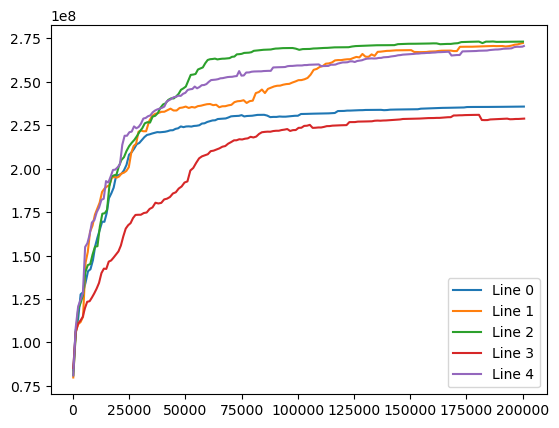

In [120]:
hvs_dicts = [hvs_dict_0, hvs_dict_1, hvs_dict_2, hvs_dict_3, hvs_dict_4]

# Iterate through dictionaries and plot lines
for i, hvs_dict in enumerate(hvs_dicts, start=1):
    lists = hvs_dict.items()
    x, y = zip(*lists)
    plt.plot(x, y, label=f'Line {i-1}')

# Show legend to differentiate between lines
plt.legend()

# Show the plot
plt.show()

for key, value in sorted_archives.items():
    o = value
    print(o.type)
    #objs = np.ascontiguousarray(o)
    #print(objs.shape)
    #array_reference_set = reference_set.values.copy()
    #hv = hvwfg.wfg(objs, 
    #               worst_array)
    #print("Key:", hv)#, "Value:", value)

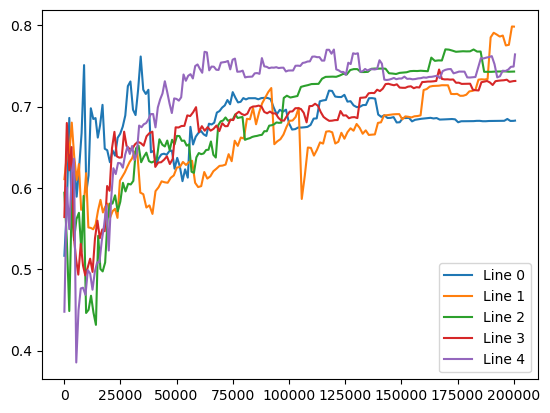

In [121]:
norm_hvs_dicts = [norm_hvs_dict_0, norm_hvs_dict_1, norm_hvs_dict_2, norm_hvs_dict_3, norm_hvs_dict_4]

# Iterate through dictionaries and plot lines
for i, norm_hvs_dict in enumerate(norm_hvs_dicts, start=1):
    lists = norm_hvs_dict.items()
    x, y = zip(*lists)
    plt.plot(x, y, label=f'Line {i-1}')

# Show legend to differentiate between lines
plt.legend()

# Show the plot
plt.show()


In [ ]:
os.getcwd()

# IRRIGATION CASE

In [84]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [85]:
from model_zambezi_OPT_irr import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, Irrigation7, \
        Irrigation8, Irrigation9 = tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, \
        Irrigation7, Irrigation8, Irrigation9
# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation2', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation3', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation4', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation5', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation6', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation7', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation8', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation9', ScalarOutcome.MINIMIZE),
                  ]


In [86]:
#Problem definitionv
problem = to_problem(model, searchover="levers")

Run definition

In [87]:
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [88]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 10000 #
seeds = 1
run_comment = 'hv_feb'
run_label = f"IR_{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\IR_hv_feb_10000nfe_1seed'

Change the load archives method of the ArchiveLogger class

In [89]:
import tarfile
import os
import pandas as pd

def alternative_load_archives(filename):
    archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                print(key)
                df = pd.read_csv(fh.extractfile(entry), index_col=0)
                #df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
                if not df.empty:
                    archives[int(key)] = df
    #print(archives)
    return archives

ArchiveLogger.load_archives = alternative_load_archives

Merge convergences 

In [90]:
convergences = []
for i in range(seeds):
    df = pd.read_csv(f"convergence{i}.csv")
    convergences.append(df)
    #f'convergence{i}' = pd.read_csv(f"{run_name}/convergence{i}.csv") 

In [91]:
# Load the archives
all_archives = []
for i in range(seeds):
    archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
    print(archives)
    all_archives.append(archives)

0
100
10056
1177
2274
3371
4465
5563
6661
7760
8761
9857
{100:          v0        v1        v2        v3        v4        v5        v6  \
0  0.928945  0.160364  0.037497  0.144293  0.142200  0.458481 -0.137220   
1  0.347099  0.860539 -0.887489  0.762720  0.016786 -0.429451 -0.930741   
2  0.923747  0.805610  0.773875 -0.694815  0.523367  0.315194 -0.097212   
3 -0.386424 -0.371589  0.981151  0.057387  0.550802  0.703063  0.158640   
4 -0.760580  0.031873 -0.529644  0.343297  0.688832 -0.965012 -0.511506   
5  0.353912 -0.785565  0.286437 -0.138169 -0.989073 -0.140371 -0.989279   
6 -0.222727 -0.151684  0.470355  0.207460  0.399557  0.355663 -0.938816   
7  0.278010 -0.748475  0.152119  0.592442 -0.347368  0.986776 -0.830709   

         v7        v8        v9  ...   Environment  Irrigation  Irrigation2  \
0 -0.965516  0.929522  0.095980  ...  2.241699e+06    1.274334     0.207649   
1  0.241618  0.416322  0.420400  ...  2.164708e+06    2.066547     0.500889   
2 -0.711462 -0.711311  0

In [111]:
# Create the results list
results_list = []
for i in range(seeds):
    result = pd.read_csv(f"results_seed{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    results_list.append(result)

In [116]:
# Define the reference list
reference_set = epsilon_nondominated(results_list, [0.05] * len(model.outcomes), problem)  # [0.05]
#print('reference_set', reference_set)
#print('reference_set type is', type(reference_set))

Index(['v0', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9',
       ...
       'Environment', 'Irrigation', 'Irrigation2', 'Irrigation3',
       'Irrigation4', 'Irrigation5', 'Irrigation6', 'Irrigation7',
       'Irrigation8', 'Irrigation9'],
      dtype='object', length=241)


EMAError: The number of columns in the archive (241) does not match the expected number of decision variables and objectives (233).

In [ ]:

hv = HypervolumeMetric(reference_set, problem)
gd = GenerationalDistanceMetric(reference_set, problem, d=1)
ei = EpsilonIndicatorMetric(reference_set, problem)
ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
sm = SpacingMetric(problem)


metrics_by_seed = []
for archives in all_archives:
    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    metrics_by_seed.append(metrics)

In [65]:
#Define the hypervolumemetric
hv = HypervolumeMetric(reference_set, problem)

In [67]:
from datetime import datetime

before = datetime.now()
print("time before is", before)

time before is 2024-02-17 00:46:56.123919


In [68]:
# Calculate the metrics
metrics_by_seed = []
for archives in all_archives:
    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "hypervolume": hv.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)

    metrics_by_seed.append(metrics)

KeyboardInterrupt: 

In [ ]:
# Visualize convergence metrics
sns.set_style("white")
fig, axes = plt.subplots(nrows=2, figsize=(8, 12), sharex=True)

ax1, ax2 = axes

for metrics, convergence in zip(metrics_by_seed, convergences):
    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")
    
sns.despine(fig)

plt.show()

In [ ]:
after = datetime.now()
print(f"It took {after - before} time to do {nfe} nfes")

# HYDROPOWER CASE

In [ ]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()

In [ ]:
from model_zambezi_OPT_hyd import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL = tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL
# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerITT', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGU', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKA', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerCB', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGL', ScalarOutcome.MINIMIZE),
                  ]


In [ ]:
#Problem definition
problem = to_problem(model, searchover="levers")

Run definition

In [ ]:
os.getcwd()

In [ ]:

nfe = 10 #
seeds = 1
run_comment = 'nobj'
run_label = f"HYD_{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()

Change the load archives method of the ArchiveLogger class

In [ ]:
import tarfile 
def alternative_load_archives(filename): #cls,
    archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                archives[int(key)] = pd.read_csv(fh.extractfile(entry), index_col=0)
    return archives

ArchiveLogger.load_archives = alternative_load_archives

Merge convergences 

In [ ]:
convergences = []
for i in range(seeds):
    df = pd.read_csv(f"convergence{i}.csv")
    convergences.append(df)
    #f'convergence{i}' = pd.read_csv(f"{run_name}/convergence{i}.csv") 

In [ ]:
# Load the archives
all_archives = []
for i in range(seeds):
    archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    all_archives.append(archives)
    
#print(all_archives)

In [ ]:
# Create the results list
results_list = []
for i in range(seeds):
    result = pd.read_csv(f"results_seed{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    results_list.append(result)

In [ ]:
# Define the reference list
reference_set = epsilon_nondominated(results_list, [0.05] * len(model.outcomes), problem)  # [0.05]
#print('reference_set', reference_set)
#print('reference_set type is', type(reference_set))

In [ ]:
#Define the hypervolumemetric
hv = HypervolumeMetric(reference_set, problem)

In [ ]:
from datetime import datetime
# Calculate the metrics
before = datetime.now()
print("time before is", before)

metrics_by_seed = []
for archives in all_archives:
    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "hypervolume": hv.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)

    metrics_by_seed.append(metrics)

after = datetime.now()
print(f"It took {after - before} time to do {nfe} metrics")


In [ ]:
# Visualize convergence metrics
sns.set_style("white")
fig, axes = plt.subplots(nrows=2, figsize=(8, 12), sharex=True)

ax1, ax2 = axes

for metrics, convergence in zip(metrics_by_seed, convergences):
    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")
    
sns.despine(fig)

plt.show()

# FULL DISAGGREGATION CASE

In [20]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [21]:
from model_zambezi_OPT_irr import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, Irrigation7,\
        Irrigation8, Irrigation9, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL = \
        tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, \
        Irrigation7, Irrigation8, Irrigation9, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL

# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation2', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation3', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation4', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation5', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation6', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation7', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation8', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation9', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerITT', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGU', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKA', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerCB', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGL', ScalarOutcome.MINIMIZE),
                  ]


In [22]:
#Problem definitionv
problem = to_problem(model, searchover="levers")

Run definition

In [23]:
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [24]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 10 #
seeds = 1
run_comment = 'test'
run_label = f"FULL_{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\IR_hv_feb_10000nfe_1seed'

Change the load archives method of the ArchiveLogger class

In [25]:
import tarfile 
def alternative_load_archives(filename): #cls,
    archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                archives[int(key)] = pd.read_csv(fh.extractfile(entry), index_col=0)
    return archives

ArchiveLogger.load_archives = alternative_load_archives

Merge convergences 

In [26]:
convergences = []
for i in range(seeds):
    df = pd.read_csv(f"convergence{i}.csv")
    convergences.append(df)
    #f'convergence{i}' = pd.read_csv(f"{run_name}/convergence{i}.csv") 

In [27]:
# Load the archives
all_archives = []
for i in range(seeds):
    archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    all_archives.append(archives)

In [28]:
# Create the results list
results_list = []
for i in range(seeds):
    result = pd.read_csv(f"results_seed{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    results_list.append(result)

In [29]:
# Define the reference list
reference_set = epsilon_nondominated(results_list, [0.05] * len(model.outcomes), problem)  # [0.05]
#print('reference_set', reference_set)
#print('reference_set type is', type(reference_set))

In [30]:
#Define the hypervolumemetric
hv = HypervolumeMetric(reference_set, problem)

In [ ]:
# Calculate the metrics
metrics_by_seed = []
for archives in all_archives:
    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "hypervolume": hv.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)

    metrics_by_seed.append(metrics)

In [ ]:
# Visualize convergence metrics
sns.set_style("white")
fig, axes = plt.subplots(nrows=2, figsize=(8, 12), sharex=True)

ax1, ax2 = axes

for metrics, convergence in zip(metrics_by_seed, convergences):
    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")
    
sns.despine(fig)

plt.show()